In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random
from scipy import stats

import spacy

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')


# 1. Preprocess and EDA

In [2]:
# read data from pickle file
data = pd.read_pickle('notes_with_age_and_impairment.pkl')

# change data types to float and int for age and life expectancy
data['age'] = data['age'].astype(float)
data['le'] = data['le'].astype(int)
data['le_year'] = data['le'].apply(lambda x: round(x/12))

data['notes_split'] = data['notes'].str.replace('\n', ' ').str.replace(r' +', ' ').str.split(' ')
data['len_notes'] = data['notes_split'].apply(len)

ave_le = np.average(data['le'].to_numpy())
mode_le = stats.mode(data['le'].to_numpy())
print('Average remaining life span: {} \nMode of remaining life span: {}'.format(ave_le, mode_le[0]))

Average remaining life span: 96.808266996657 
Mode of remaining life span: [72]


## 1.1 First glance of our data

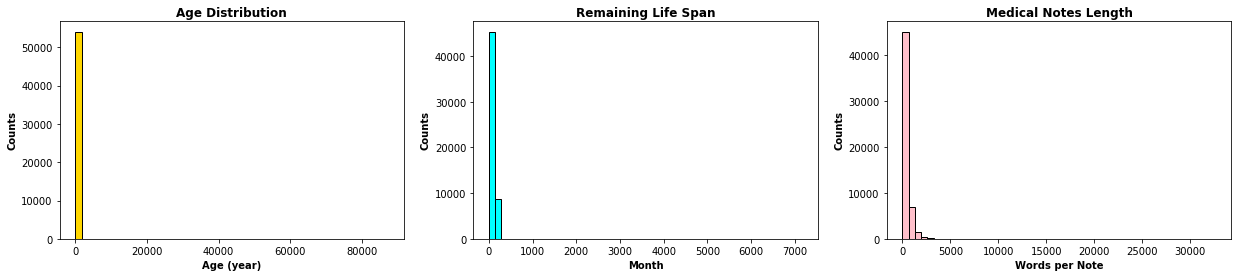

In [3]:
# First glanse of our data
eda = ['age','le','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(data[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

# plt.figure(figsize=(4,3))
# plt.hist(data['age'], bins=50, color='gold', ec='black')
# plt.xlabel('Age (year)', fontsize=10,fontweight ='bold')
# plt.ylabel('Counts', fontsize=10,fontweight ='bold')
# plt.title('Age Distribution', fontsize=12, fontweight ='bold',pad =5)

## 1.2 Preprocess (remove missing/wrong/unrealistic samples) & EDA graphs

In [4]:
filt = (data['len_notes']<=2000) & (data['len_notes']>=10) & (data['le'] <=250) & (data['age'] <=110) & (data['age'] >=60)
datafilt = data[filt]
print(data.shape, datafilt.shape) #97% data remained

(54143, 8) (52516, 8)


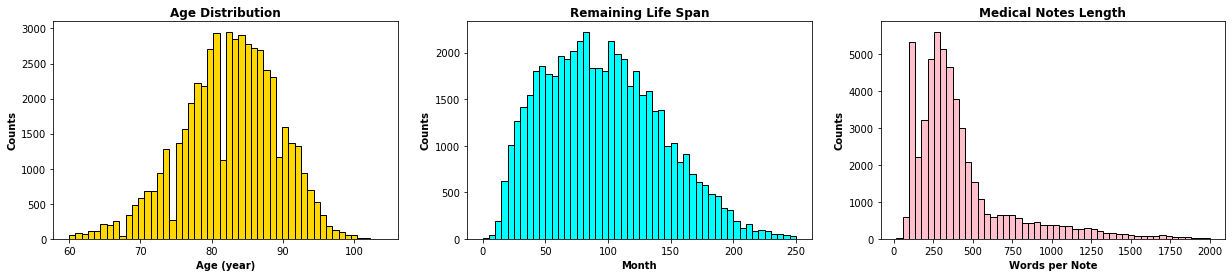

In [5]:
eda = ['age','le','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(datafilt[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

## 1.3 Word cloud

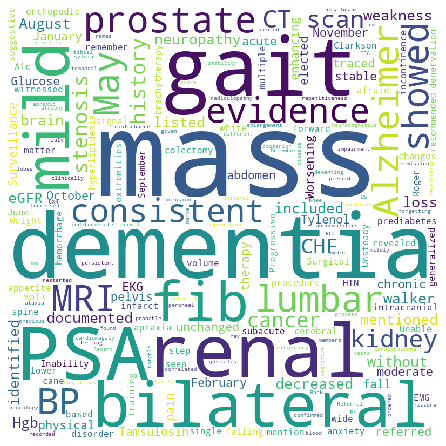

In [7]:
# data = pd.read_pickle('clean_note_spacy_vec.pkl')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

filtwc = (data['len_notes'] >= 500) & (data['len_notes'] <= 600)
notewc = data.loc[filtwc, 'notes']
notewc.index = range(notewc.shape[0])

a = random.randrange(len(notewc))

STOPWORDS.update(['noted', 'was', 'say','Was','reported','cited','Vv', 'vv','Wa'])
stopwords = set(STOPWORDS)

wc = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords)
wc.generate(notewc[a])

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
# wc.to_file('note_wc.png')

# 2. Data Cleaning and Text preprocessing

## 2.1 Remove non alphanumeric characters

In [8]:
import string
from scipy import stats
def clean(note):
    table = str.maketrans('', '','!"#$%&\'()*+,-./:;<=>?@‘¥£’—“[\\]^_`{|}~«»§é')
    s = note.translate(table)
    s1 = s.replace('\n',' ').lower()
    s2 = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s1)
    st_clean = re.sub(r' +', ' ', s2)
    return st_clean

data['notes_clean'] = data['notes'].progress_apply(lambda x: clean(x))
data['len_clean'] = data['notes_clean'].progress_apply(lambda x: len(x.split(' ')))

import spacy
nlp = spacy.load('en_core_web_lg')
data['spacy_notes_clean'] = data['notes_clean'].progress_apply(lambda x: nlp(x).vector)
data.to_pickle('clean_note_spacy_vec.pkl')
# saved pkl file NO.1
# columns =['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year',
#           'notes_split','len_notes', 'notes_clean', 'len_clean', 'spacy_notes_clean']

### saved pkl file NO.1 columns =
**`['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year','notes_split','len_notes',
'notes_clean', 'len_clean', 'spacy_notes_clean']`**

## 2.2 Tokenization, remove stopwords, stemming, lemmatization

In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def lemma_stem_stop(note):
    word_tokens = word_tokenize(note)
    
    # lemmatization
    lemma_words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in word_tokens:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        lemma_words.append(word3)

    # STOPWORDS
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
              "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
              "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
              "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    states = [x.lower() for x in states]
    
    stopwd = set(stopwords.words('english'))
    stopwd.update(['note', 'was', 'say','cite','report','vv','ii','iii','report', 'disclaim','disclaimer',
                   'request','underwrite','underwriter','life','expect','certify','take','company',
                  'id','written','write','ssn','social','security','number','llc','use']) 
    stopwd.update(states)
    filtered_sentence = [w for w in lemma_words if not w in stopwd] # can switch lemma or stem words
    
    #Stemming
    Stem_words = []
    ps =PorterStemmer()
    for w in filtered_sentence:
        rootWord=ps.stem(w)
        Stem_words.append(rootWord)
    
    lemma_stop_stem = Stem_words
    return lemma_stop_stem

In [12]:
data['lss_notes'] = data['notes_clean'].progress_apply(lambda x: lemma_stem_stop(x))
data['len_lss'] = data['lss_notes'].progress_apply(lambda x: len(x))
data['lss_corpus'] = data['lss_notes'].progress_apply(lambda x: ' '.join(x))

## 2.3 Feature Extraction (Vectorize by spacy, or Bag of words, or TF-IDF)

### Spacy vectorization

In [16]:
# vectorize cleaned corpus by spacy 
data['spacy_lss_corpus'] = data['lss_corpus'].progress_apply(lambda x: nlp(x).vector)

#### saved pkl file NO.2 columns =
**`['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year', 'notes_split', 'len_notes', 
'notes_clean', 'len_clean', 'spacy_notes_clean', 
'lss_notes', 'len_lss', 'lss_corpus', 'spacy_lss_corpus']`**

In [17]:
data.to_pickle('clean_note_spacy_vec_lss_spacy.pkl')
# saved pkl file NO.2
# columns = ['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year', 'notes_split', 'len_notes', 'notes_clean', 
#           'len_clean', 'spacy_notes_clean', 'lss_notes', 'len_lss', 'lss_corpus','spacy_lss_corpus']

### Bag of Words, TF-IDF

In [18]:
data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl') #load data for tf-idf

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (data['len_lss']<=2000) & (data['len_lss']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_tfidf = data[filt][['age', 'le','le_year','lss_notes','lss_corpus']]

corpus = data_tfidf['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf data most frequent 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

# 3. Prepare data for model

### 3.1 Load spacy vectorized notes for  Model input

In [20]:
# # data=pd.read_pickle('clean_note_spacy_vec.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data1 = data[filt]

X = data1['spacy_notes_clean'].to_numpy()
X = np.array([i for i in X]).reshape(52475,300) #X = np.concatenate(X).reshape(54143,300)
x_age = np.expand_dims(data1['age'].to_numpy(), axis=1)

X = np.hstack((x_age, X))
y = data1['le'].to_numpy() 

### 2.Load spacy vectorize lss_corpus for Model input

In [21]:
# # data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_spacylss_filt = data[filt]

X = np.array(data_spacylss_filt['spacy_lss_corpus'].values.tolist())
x_age = np.expand_dims(data_spacylss_filt['age'].to_numpy(), axis=1)

# X y from spacy vector of lss_corpus for Model
X = np.hstack((x_age, X))
y = data_spacylss_filt['le'].to_numpy() 
# y = data_spacylss_filt['le_year']

### 3.Vectorized X, y from TF-IDF for Model input

In [22]:
X = corpus_tfidf.toarray()
x_age = np.expand_dims(data_tfidf['age'].to_numpy(), axis = 1)

# X y from tf-idf for Model
X = np.hstack((x_age, X))
y = data_tfidf['le'].to_numpy() 

In [23]:
print(X.shape, y.shape)

(53020, 4001) (53020,)


# 4. Model

In [24]:
print(X.shape, y.shape)

(53020, 4001) (53020,)


In [25]:
from sklearn.model_selection import train_test_split
# 80%/20% split for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [27]:
# df_y_pred dataframe to store y_pred from model
# df_score dataframe to store mae, train_r2, test_r2
df_pred_ytest = pd.DataFrame()
df_pred_ytrain = pd.DataFrame()
df_score = pd.DataFrame(index=['MAE','train_r2','test_r2'])

##  Random Forest

### 4.1 RF model & feature importances

In [28]:
from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 30, random_state = 0)

reg_rf = RandomForestRegressor().fit(X_train, y_train)
y_test_rf = reg_rf.predict(X_test)
y_train_rf = reg_rf.predict(X_train)

# feature importances from model
importances = reg_rf.feature_importances_

# R squared from model
rf_train_score = reg_rf.score(X_train, y_train)
rf_test_score = reg_rf.score(X_test, y_test)

# calculate mean absolute residual
rf_mae = sum(np.absolute(y_test_rf - y_test))/y_test.size

9.797897941158455 0.9840899361381341 0.8854179808205834


In [40]:
print('Residual = {} \nTraining data R2 = {} \nTesting data R2 = {}'.format(rf_mae, rf_train_score, rf_test_score))

Residual = 9.797897941158455 
Training data R2 = 0.9840899361381341 
Testing data R2 = 0.8854179808205834


In [29]:
# save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf'] = y_train_rf
df_pred_ytest['y_test_rf'] = y_test_rf
df_score['rf'] =[rf_mae, rf_train_score, rf_test_score]

4001 4001


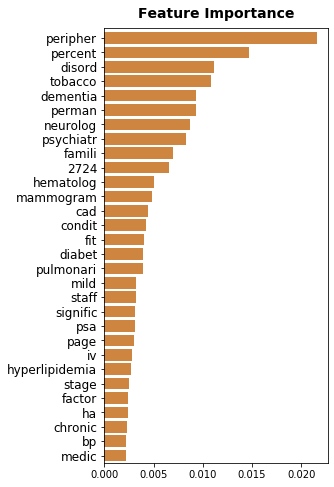

In [30]:
# plot feature importances
vip_idx = np.argsort(np.absolute(importances))[::-1]
importances_sort = [importances[i] for i in vip_idx]

vocab.insert(0,'age') 
vip_name = [vocab[i] for i in vip_idx]
print(len(vocab), len(vip_name))

plt.figure(figsize=(4,8))
plt.barh(range(30)[::-1], importances_sort[1:31], color = 'peru')
plt.yticks(range(30)[::-1], vip_name[1:31], rotation =0, fontsize =12)
plt.ylim(-0.5,29.7)
plt.title('Feature Importance', fontweight='bold', pad =10, fontsize=14)
plt.show()

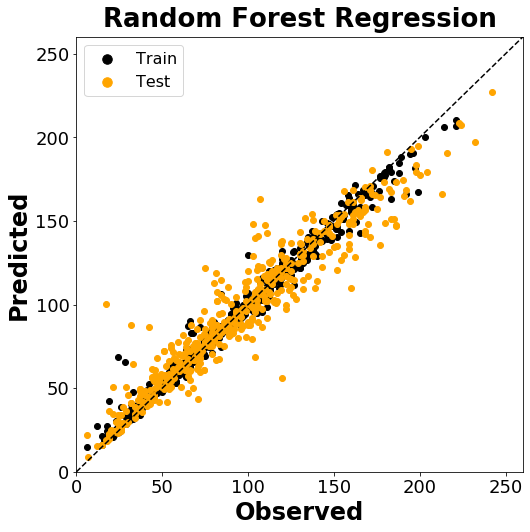

In [31]:
# plot R-squared graphs
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1500], y_train_rf[1000:1500], label = 'Train', color='black')
plt.scatter(y_test[1000:1500], y_test_rf[1000:1500], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Random Forest Regression', fontsize =26, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =24, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =24, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
plt.show()
# plt.savefig('Random Forest predicted vs observed.png', dpi = 400)

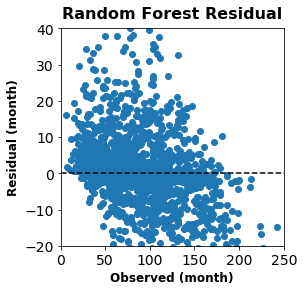

In [37]:
# plot residual graphs

# residual = np.absolute(y_test_rf - y_test)
residual = y_test_rf - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[:1500], residual[:1500])
plt.axhline(y=0, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Random Forest Residual', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed (month)',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual (month)',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
# plt.savefig('RF Residual.png', dpi =400)

### 4.2 RF model with only age as input (ablation study)

In [ ]:
# age as the only input
reg_rf = RandomForestRegressor(n_estimators = 40, random_state = 0)
reg_rf = RandomForestRegressor().fit(np.expand_dims(X_train[:, 0], axis=1), y_train)

y_test_rf1 = reg_rf.predict(np.expand_dims(X_test[:, 0], axis=1))
y_train_rf1 = reg_rf.predict(np.expand_dims(X_train[:, 0], axis=1))

rf_train_score1 = reg_rf.score(np.expand_dims(X_train[:, 0], axis=1), y_train)
rf_test_score1 = reg_rf.score(np.expand_dims(X_test[:, 0], axis=1), y_test)

rf1_mae = sum(np.absolute(y_test_rf1-y_test))/y_test.size

print(rf1_mae, rf_train_score1, rf_test_score1) # R^2 variance weighted

In [34]:
# # save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf_age'] = y_train_rf1
df_pred_ytest['y_test_rf_age'] = y_test_rf1
df_score['rf_age'] =[rf1_mae, rf_train_score1, rf_test_score1]
# df_score

### 4.3 Save df_pred_ytrain, df_pred_ytest, df_score to csv file

In [35]:
# #Save predicted y values and R2 scores to csv file
df_pred_ytrain.to_csv('df_pred_ytrain.csv')
df_pred_ytest.to_csv('df_pred_ytest.csv')
df_score.to_csv('df_score.csv')